## RL POLICY NETWORK USING MCTS SELF PLAY

In [1]:
import chess
import chess.engine
import pygame
import random
import pickle
import numpy as np
import tensorflow as tf
from IPython.display import Audio
from collections import defaultdict
from tqdm import tqdm

pygame 2.5.2 (SDL 2.28.3, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


UTILITY FUNCTIONS

In [2]:
def parse_fen(fen):
    #print(fen)
    #flipping the board for perspective
    file_to_num = {'a': 1, 'b': 2, 'c': 3, 'd':4, 'e':5, 'f':6, 'g':7, 'h':8}
    enc = np.zeros([8,8,18]).astype(int)
    fen_elem = fen.split(' ')
    fen_pos = fen_elem[0]
    if fen_elem[1] == 'w':
        player = 1
        enc_dict = {"R":0, "N":1, "B":2, "Q":3, "K":4, "P":5, "r":6, "n":7, "b":8, "q":9, "k":10, "p":11}
    else:
        player = 0
        enc_dict = {"r":0, "n":1, "b":2, "q":3, "k":4, "p":5, "R":6, "N":7, "B":8, "Q":9, "K":10, "P":11}
    enc[:,:,12] = player
    castle = fen_elem[2]
    if player:
        if 'Q' not in castle:
            enc[:,:,13] = 1
        if 'K' not in castle:
            enc[:,:,14] = 1
        if 'q' not in castle:
            enc[:,:,15] = 1
        if 'k' not in castle:
            enc[:,:,16] = 1
    else:
        if 'Q' not in castle:
            enc[:,:,15] = 1
        if 'K' not in castle:
            enc[:,:,16] = 1
        if 'q' not in castle:
            enc[:,:,13] = 1
        if 'k' not in castle:
            enc[:,:,14] = 1
    enc[:,:,17] = int(fen_elem[-1])
    ranks = fen_pos.split('/')
    for i, rank in enumerate(ranks):
        j = 0
        k = 0
        while k < len(rank):
            if rank[k].isdigit():
                j += int(rank[k])
                k += 1
                continue
            enc[(7 - i)*player + (1 - player)*i, j*player + (1 - player)*(7 - j), enc_dict[rank[k]]] = 1
            j += 1
            k += 1
    return enc

In [3]:
def parse_actions(move, fen):
    if fen.split(' ')[1] == 'w':
        player = 1
    else:
        player = 0
    enc = np.zeros([8,8,73]).astype(int)
    file_to_num = {'a': 1, 'b': 2, 'c': 3, 'd':4, 'e':5, 'f':6, 'g':7, 'h':8}
    init_file = file_to_num[move[0]]
    init_rank = int(move[1])
    final_file = file_to_num[move[2]]
    final_rank = int(move[3])
    under_promo = move[-1] if move[-1] in ['n', 'N', 'b', 'B', 'r', 'R'] else None
    file_diff = (init_file - final_file)*player + (final_file - init_file)*(1 - player)
    rank_diff = (init_rank - final_rank)*player + (final_rank - init_rank)*(1 - player)
    if under_promo is not None: #underpromotions
        if file_diff == 0: #no capture
            if under_promo in ['r', 'R']:
                idx = 64
            elif under_promo in ['b', 'B']:
                idx = 65
            else:
                idx = 66
        elif file_diff > 0: # left capture
            if under_promo in ['r', 'R']:
                idx = 67
            elif under_promo in ['b', 'B']:
                idx = 68
            else:
                idx = 69
        else: # right capture
            if under_promo in ['r', 'R']:
                idx = 70
            elif under_promo in ['b', 'B']:
                idx = 71
            else:
                idx = 72
    elif file_diff == 0: #NS direction
        if rank_diff < 0: #upward
            idx = -rank_diff - 1
        else: #downward
            idx = 6 + rank_diff
    elif rank_diff == 0: #EW direction
        if file_diff < 0: #right
            idx = 13 - file_diff
        else: #left
            idx = 20 + file_diff
    elif abs(file_diff) == abs(rank_diff): #diagonal moves
        if rank_diff < 0 and file_diff < 0: #NE
            idx = 27 - rank_diff
        elif rank_diff > 0 and file_diff > 0: #SW
            idx = 34 + rank_diff
        elif rank_diff < 0 and file_diff > 0: #NW
            idx = 41 + file_diff
        else: #SE
            idx = 48 + rank_diff
    elif file_diff == 1 and rank_diff == -2:
        idx = 56
    elif file_diff == -1 and rank_diff == -2:
        idx = 57
    elif file_diff == 2 and rank_diff == 1:
        idx = 58
    elif file_diff == 2 and rank_diff == -1:
        idx = 59
    elif file_diff == 1 and rank_diff == 2:
        idx = 60
    elif file_diff == -1 and rank_diff == 2:
        idx = 61
    elif file_diff == -2 and rank_diff == 1:
        idx = 62
    elif file_diff == -2 and rank_diff == -1:
        idx = 63
    enc[(init_rank - 1)*player + (8 - init_rank)*(1 - player), (init_file - 1)*player + (8 - init_file)*(1 - player), idx] = 1
    return enc.flatten(), (init_file - 1)*player + (8 - init_file)*(1 - player), (init_rank - 1)*player + (8 - init_rank)*(1 - player), idx

In [4]:
def decode_action(out_policy, fen):
    policy_dict = dict({})
    board = chess.Board(fen)
    legal_moves = list(board.legal_moves)
    for move in legal_moves:
        _, x, y, z = parse_actions(str(move), fen) #x = file, y = rank
        policy_dict[move] = out_policy[y, x, z]
    return policy_dict 

In [5]:
def beep():
    beep_sound = Audio(filename = "beep-01.wav", autoplay = True)
    return beep_sound

NETWORK BLOCKS

In [6]:
@tf.keras.utils.register_keras_serializable()
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.conv = tf.keras.layers.Conv2D(filters, kernel_size, padding = 'same')
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x

@tf.keras.utils.register_keras_serializable()
class ResBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding = 'same')
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding = 'same')
        self.batch_norm2 = tf.keras.layers.BatchNormalization()

    def call(self, inputs):
        out = self.conv1(inputs)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.batch_norm2(out)
        return self.relu(out + inputs)
    
@tf.keras.utils.register_keras_serializable()
class PolicyHead(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, num_move_planes, **kwargs):
        super(PolicyHead, self).__init__(**kwargs)
        self.conv = tf.keras.layers.Conv2D(filters, kernel_size, padding = 'same')
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(num_move_planes * 8 * 8, activation = 'softmax')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

@tf.keras.utils.register_keras_serializable()
class ValueHead(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(ValueHead, self).__init__(**kwargs)
        self.conv = tf.keras.layers.Conv2D(filters, kernel_size, padding = 'same')
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(64, activation = 'relu')
        self.dense2 = tf.keras.layers.Dense(1, activation = 'tanh')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

NODE/GAME STATE CLASS

In [7]:
class node:
    def __init__(self, fen, P, W = 0, N = 0):
        """
        W = total value score for the action
        N = Number of times action taken
        P = Prior probability of the action from the SL network
        """
        self.fen = fen
        self.W = W
        self.N = N
        self.P = P
        if N == 0:
            self.Q = 0
        else:
            self.Q = W/N
        self.child = []
        self.actions = []

In [8]:
# def game_end(fen):
#     b = chess.Board(fen)
#     leg_moves = list(b.legal_moves)
#     if len(leg_moves) == 0 or b.halfmove_clock == 100:
#         return 1
#     return 0

In [9]:
def game_end(board):
    leg_moves = list(board.legal_moves)
    if len(leg_moves) == 0 or board.halfmove_clock == 100:
        return 1
    return 0

In [10]:
# def game_res(fen):
#     b = chess.Board(fen)
#     if b.is_checkmate(): #win for either side
#         return 1
#     return 0 #draw

In [11]:
def game_res(board):
    if board.is_checkmate(): #win for either side
        return 1
    return 0 #draw

LOADING THE MODELS

In [12]:
value_model = tf.keras.models.load_model('C:/Users/DELL/Downloads/value_model13.h5')
policy_model = tf.keras.models.load_model('C:/Users/DELL/Downloads/policy_model_res11.h5')

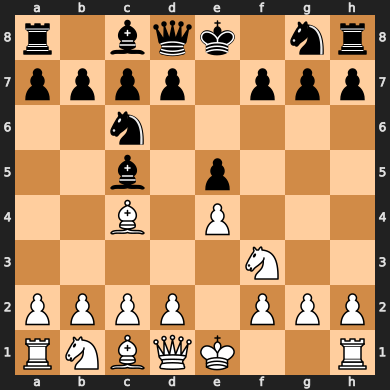

In [13]:
b = chess.Board('r1bqk1nr/pppp1ppp/2n5/2b1p3/2B1P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 4')
# b.push(chess.Move.from_uci('g2g4'))
# b.push(chess.Move.from_uci('h7h5'))
display(b)

In [14]:
decode_action(policy_model.predict(np.array([parse_fen('r1bqk1nr/pppp1ppp/2n5/2b1p3/2B1P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 4')]), verbose = 0)[0].reshape((8,8,73)), 'r1bqk1nr/pppp1ppp/2n5/2b1p3/2B1P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 4')

{Move.from_uci('c4f7'): 6.2731495e-05,
 Move.from_uci('c4e6'): 9.196387e-05,
 Move.from_uci('c4a6'): 4.0764255e-07,
 Move.from_uci('c4d5'): 8.782018e-05,
 Move.from_uci('c4b5'): 0.0018836113,
 Move.from_uci('c4d3'): 7.371598e-05,
 Move.from_uci('c4b3'): 0.0044525526,
 Move.from_uci('c4e2'): 2.7542761e-05,
 Move.from_uci('c4f1'): 1.0236866e-05,
 Move.from_uci('f3g5'): 0.00066685845,
 Move.from_uci('f3e5'): 0.0012502667,
 Move.from_uci('f3h4'): 1.4851178e-05,
 Move.from_uci('f3d4'): 1.1147082e-05,
 Move.from_uci('f3g1'): 5.262654e-07,
 Move.from_uci('h1g1'): 2.5513268e-07,
 Move.from_uci('h1f1'): 9.809323e-07,
 Move.from_uci('e1e2'): 0.000120196324,
 Move.from_uci('e1f1'): 6.4191576e-05,
 Move.from_uci('d1e2'): 0.0009843037,
 Move.from_uci('b1c3'): 0.052893348,
 Move.from_uci('b1a3'): 2.071033e-06,
 Move.from_uci('e1g1'): 0.18387671,
 Move.from_uci('h2h3'): 0.0032396992,
 Move.from_uci('g2g3'): 0.00016344346,
 Move.from_uci('d2d3'): 0.50992763,
 Move.from_uci('c2c3'): 0.19222558,
 Move.f

In [15]:
def simul(state, policy_model, value_model, side_to_play):
    """
    Function to perform single simulation of MCTS (selection of best move + expansion of leaf node)
    """
    # stockfish_path = r"C:\Users\DELL\Desktop\stockfish\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2"
    # engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)
    state_turn = chess.Board(state.fen).turn
    #print(state.fen, len(state.child))
    if state.N == 0: #checking for leaf node
        b = chess.Board(state.fen)
        leg_moves = b.legal_moves
        state.actions = list(leg_moves)
        out_policy = policy_model.predict(np.array([parse_fen(state.fen)]), verbose = 0)[0].reshape((8, 8, 73))
        policy_dict = decode_action(out_policy, state.fen)
        for move in leg_moves:
            move_prob = policy_dict[move]
            b.push(move)
            state.child.append(node(b.fen(), move_prob))
            move_val = game_res(b) if game_end(b) else value_model.predict(np.array([parse_fen(b.fen())]), verbose = 0)[0][0]
            # eval = str(engine.analyse(b, chess.engine.Limit(time = 0.1))['score'].white())
            # if eval[-1] == '#':
            #     if eval[0] == '-':
            #         move_val = -10000
            #     else:
            #         move_val = 10000
            # else:
            #     move_val = int(eval)
            # move_val = side_to_play*move_val - (1 - side_to_play)*move_val
            state.W += (int(state_turn) == side_to_play)*move_val - (1 - (int(state_turn) == side_to_play))*move_val
            b.pop()
    else:
        ucb_scores = []
        for child in state.child:
            #EVAL THE BEST MOVE USING UCB
            U = 2*child.P*np.sqrt(state.N)/(1 + child.N) #choosing c = 1 for the UCB, exploration parameter
            #print(U, child.Q, child.Q + U)
            ucb_scores.append(child.Q + U)
        #print(ucb_scores), np.argmax(ucb_scores))
        if len(ucb_scores):
            max_idx = np.argmax(ucb_scores)
            best_child_W = state.child[max_idx].W
            best_move_val = simul(state.child[max_idx], policy_model, value_model, side_to_play) - best_child_W  
            state.W += (int(state_turn) == side_to_play)*best_move_val - (1 - (int(state_turn) == side_to_play))*best_move_val
    state.N += 1
    state.Q = state.W/state.N
    return state.W

In [16]:
def MCTS(root, policy_model, value_model, side_to_play, num_simul = 10): #root is the current game state/ node
    for i in range(num_simul):
        #print(i)
        simul(root, policy_model, value_model, side_to_play)
    # ucb_scores = []
    # for child in root.child:
    #     U = 1*child.P*np.sqrt(node.N)/(1 + child.N) #choosing c = 1 for the UCB
    #     ucb_scores.append(child.Q + U)
    # best_idx = np.argmax(ucb_scores)
    # prob = [child.N/root.N for child in root.child]
    # samp_idx = random.choices(np.arange(len(root.child)), weights = prob, k = 1)[0]
    best_idx = np.argmax([child.N for child in root.child])
    #return samp_idx
    return best_idx

In [17]:
def play_stockfish(root, engine, engine_color, policy_model, value_model, num_simul, time_limit = 1): #1 for white, 0 for black
    board = chess.Board(root.fen)
    cp_loss = []
    while not game_end(board):
        if int(board.turn) == engine_color:
            move = engine.play(board, chess.engine.Limit(time = time_limit)).move
            board.push(move)
            root = node(board.fen(), not engine_color)
        else:
            best_idx = MCTS(root, policy_model, value_model, not engine_color, num_simul)
            try:
                eval_init_w = int(str(engine.analyse(board, chess.engine.Limit(time = time_limit))['score'].white()))
                int_eval_init = (1 - 2*engine_color)*eval_init_w
            except:
                break
            move = root.actions[best_idx]
            #root = root.child[best_idx]
            board.push(move)
            try:
                eval_final_w = int(str(engine.analyse(board, chess.engine.Limit(time = time_limit))['score'].white()))
                int_eval_final = (1 - 2*engine_color)*eval_final_w
                cp_loss.append(int_eval_init - int_eval_final)
            except:
                break
        print(move)
    return cp_loss

PLAYING AGAINST STOCKFISH AND COLLECTING CENTIPAWN LOSSES

In [18]:
# # 10 different opening positions
# start_fens = [
#     'r1bqk1nr/pppp1ppp/2n5/1Bb1p3/4P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 4', 
#     'rnbqkb1r/ppp2ppp/5n2/3p4/3P4/2N5/PP2PPPP/R1BQKBNR w KQkq - 0 5',
#     'rnbqk2r/pppp1ppp/4pn2/8/1bPP4/2N5/PP2PPPP/R1BQKBNR w KQkq - 0 4',
#     'rnbqkb1r/pp2pp1p/3p1np1/8/3NP3/2N5/PPP2PPP/R1BQKB1R w KQkq - 0 6',
#     'r1bqkb1r/pppp1ppp/2n2n2/4p3/3PP3/2N2N2/PPP2PPP/R1BQKB1R b KQkq - 0 4',
#     'rn1qkbnr/pp2pppp/2p5/5b2/3PN3/8/PPP2PPP/R1BQKBNR w KQkq - 0 5',
#     'rnbqkb1r/pp3p1p/3p1np1/2pP4/8/2N2NP1/PP2PP1P/R1BQKB1R b KQkq - 0 7',
#     'rnbqkb1r/pp4pp/2p1pn2/3p1p2/2PP4/5NP1/PP2PPBP/RNBQK2R w KQkq - 0 6',
#     'r1bqk2r/ppp2ppp/2np1n2/2b1p1B1/2B1P3/2NP1N2/PPP2PPP/R2QK2R b KQkq - 0 6',
#     'rnbqkbnr/ppp2ppp/8/3p4/3P4/8/PPP2PPP/RNBQKBNR w KQkq - 0 4'
# ]
# start_fens = start_fens + start_fens
# # 1 for white, 0 for black
# engine_colors = [1]*10 + [0]*10
# stockfish_path = r"C:\Users\DELL\Desktop\stockfish\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2"
# engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

In [19]:
root = node('r1bqk1nr/pppp1ppp/2n5/2b1p3/2B1P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 4', 1)
stockfish_path = r"C:\Users\DELL\Desktop\stockfish\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2"
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)
loss = np.mean(play_stockfish(root, engine, 1, policy_model, value_model, 3))
elo = 3100*np.exp(-0.01*loss)
print(loss)
print(elo)

d2d3
g8f6
c2c3
e8g8
e1g1
h7h6
b2b4
c5e7
c1b2
d7d6
f1e1
a7a6
b1d2
c8e6
a2a3
d8d7
d1c2
e6g4
d3d4
f6h7
c4f1
h7g5
d4d5
c6b8
f3g5
e7g5
c3c4
h6h5
f2f3
g4e6
d2b3
e6g4
f3g4
d7g4
f1e2
g4c8
e2h5
b8d7
h5g4
d7f6
g4c8
f8c8
b3a5
f6d7
a5b7
a8b8
b7a5
g5d2
c2d2
f7f6
d2f2
g8f7
f2f5
39.57692307692308
2086.8022715994152


In [ ]:
beep()

In [17]:
start_fens = ['r1bqk1nr/pppp1ppp/2n5/2b1p3/2B1P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 4']*2
engine_colors = [0, 1]

In [18]:
cp_loss_master = []
cp_loss_n = []
stockfish_path = r"C:\Users\DELL\Desktop\stockfish\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2"
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

In [19]:
# root = node('r1bqk1nr/pppp1ppp/2n5/2b1p3/2B1P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 4', 1)
# cp_loss_n.append(play_stockfish(root, engine, 0, policy_model, value_model, 50))
# del root

In [21]:
cp_loss_master = []
#num_simuls = [5, 10, 50, 100]
num_simuls = [6]
for num_simul in tqdm(num_simuls):
    cp_loss_n = []
    for i, start_fen in tqdm(enumerate(start_fens)):
        root = node(start_fen, 1)
        cp_loss_n.append(play_stockfish(root, engine, engine_colors[i], policy_model, value_model, num_simul))
        del root
    cp_loss_master.append(cp_loss_n)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]

d2d3
g8f6
e1g1
d7d6
b1c3
c6a5
c4b5
c7c6
b5a4
b7b5
a4b5
c6b5
c3b5
e8g8
c1g5
h7h6
g5f6
d8f6
b5c3
a5c6
c3d5
f6d8
c2c3
a7a5
f3d2
c6e7
d5e7
d8e7
d2c4
c8e6
c4e3
c5a7
d1d2
e7g5
g2g3
f7f5
e3f5
g5d2
f5e7
g8h7



1it [04:30, 270.17s/it]

c2c3
g8f6
d2d3
e8g8
e1g1
h7h6
d3d4
c5d4
c3d4
e5d4
f3d4
f8e8
b1c3


1it [06:06, 366.41s/it]
  0%|                                                                                            | 0/1 [06:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
with open('cp_loss_c1.pkl', 'wb') as m:
    pickle.dump(cp_loss_master, m)

In [ ]:
cp_loss_avg = np.array([0.5*(np.mean(row[0]) + np.mean(row[1])) for row in cp_loss_master])
cp_loss_avg

In [ ]:
elo = 3100*np.exp(-0.01*cp_loss_avg)
elo

for c = 2 (high exploration factor),
1. @ n = 3, elo = 2123
2. @ n = 5, elo = 234 ??
3. @ n = 10, elo = 1561 </ol>
for c = 1 (low exploration factor),
1. @ n = 3, elo = 
2. @ n = 5, elo = 
3. @ n = 10, elo =  </ol>


In [ ]:
beep()